In [ ]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import time
import os

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/project/')

In [ ]:
from unet import UNet, Decoder, Encoder
from preparationDataset import PreparationDataset
from prediction import make_predictions
from earlyStopping import EarlyStopping
from IOU import IOU

# 1. Preparation of The Dataset

In [ ]:

dataset_path = "/content/drive/My Drive/Colab Notebooks/project/"

image_path = os.path.join(dataset_path, 'images')
masked_path = os.path.join(dataset_path, 'masks')
TEST_SPLIT = 0.10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

In [ ]:

INIT_LR = 2e-4
NUM_EPOCHS = 300
BATCH_SIZE = 8

INPUT_IMAGE_WIDTH = 1024
INPUT_IMAGE_HEIGHT = 1024

BASE_OUTPUT = dataset_path+"output"

MODEL_PATH = os.path.join(BASE_OUTPUT, "MODEL.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "Train_Test_Plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_path.txt"])

### Data Transformation 


### Splitting of the Dataset

In [ ]:
from imutils import paths
from sklearn.model_selection import train_test_split
from torch.nn import Module

In [ ]:
imagePaths = sorted(list(paths.list_images(image_path)))
maskPaths = sorted(list(paths.list_images(masked_path)))

split = train_test_split(imagePaths, maskPaths,test_size=TEST_SPLIT, random_state=42)

(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [ ]:

transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((512,512)),transforms.ToTensor()])

trainDS = PreparationDataset(imagePaths=trainImages, maskPaths=trainMasks,transforms=transforms)
testDS = PreparationDataset(imagePaths=testImages, maskPaths=testMasks,transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

trainLoader = DataLoader(trainDS, shuffle=False,batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=os.cpu_count())

[INFO] found 5603 examples in the training set...
[INFO] found 623 examples in the test set...


# 2. U-NET

In [ ]:
#define the loss and optimization functions
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

In [ ]:
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

# 3. Training

### Early Stopping 





In [ ]:
early_stopping=EarlyStopping()

### Training the Model

In [ ]:
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
  unet.train()
  totalTrainLoss = 0
  totalTestLoss = 0

  for (i, (x, y)) in enumerate(trainLoader):
    (x, y) = (x.to(DEVICE), y.to(DEVICE))
    pred = unet(x)
    loss = lossFunc(pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    totalTrainLoss += loss

  with torch.no_grad():
    unet.eval()
    for (x, y) in testLoader:
      (x, y) = (x.to(DEVICE), y.to(DEVICE))
      pred = unet(x)
      totalTestLoss += lossFunc(pred, y)
  avgTrainLoss = totalTrainLoss / trainSteps
  avgTestLoss = totalTestLoss / testSteps
  H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
  early_stopping(avgTrainLoss,avgTestLoss)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
  print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
  print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|          | 0/300 [00:00<?, ?it/s]

[INFO] EPOCH: 1/300
Train loss: 0.163944, Test loss: 0.1523
[INFO] EPOCH: 2/300
Train loss: 0.138080, Test loss: 0.1301
[INFO] EPOCH: 3/300
Train loss: 0.114822, Test loss: 0.1066
[INFO] EPOCH: 4/300
Train loss: 0.099955, Test loss: 0.0987
[INFO] EPOCH: 5/300
Train loss: 0.093064, Test loss: 0.0929
[INFO] EPOCH: 6/300
Train loss: 0.088503, Test loss: 0.0897
[INFO] EPOCH: 7/300
Train loss: 0.085027, Test loss: 0.0870
[INFO] EPOCH: 8/300
Train loss: 0.082315, Test loss: 0.0854
[INFO] EPOCH: 9/300
Train loss: 0.080008, Test loss: 0.0834
[INFO] EPOCH: 10/300
Train loss: 0.078044, Test loss: 0.0812
[INFO] EPOCH: 11/300
Train loss: 0.076309, Test loss: 0.0794
[INFO] EPOCH: 12/300
Train loss: 0.074757, Test loss: 0.0782
[INFO] EPOCH: 13/300
Train loss: 0.073308, Test loss: 0.0767
[INFO] EPOCH: 14/300
Train loss: 0.072042, Test loss: 0.0754
[INFO] EPOCH: 15/300
Train loss: 0.070898, Test loss: 0.0743
[INFO] EPOCH: 16/300
Train loss: 0.069862, Test loss: 0.0737
[INFO] EPOCH: 17/300
Train loss: 

### Train-Test Loss Graph

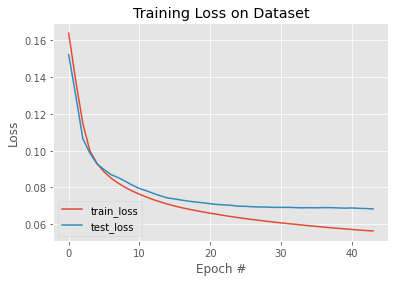

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
torch.save(unet, MODEL_PATH)

# 4. Prediction

[INFO] loading up test image paths...
[INFO] load up model...


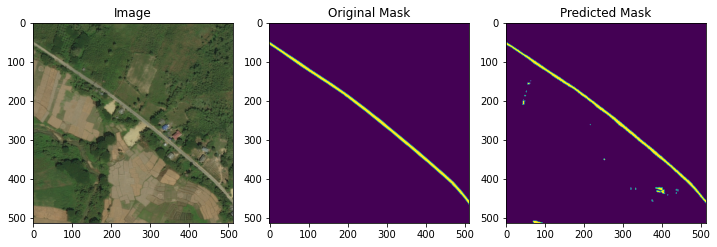

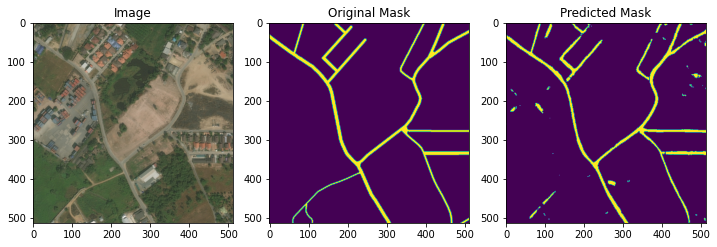

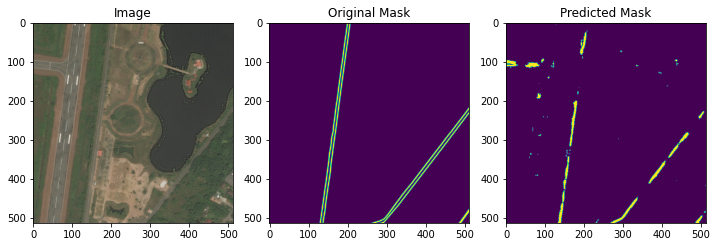

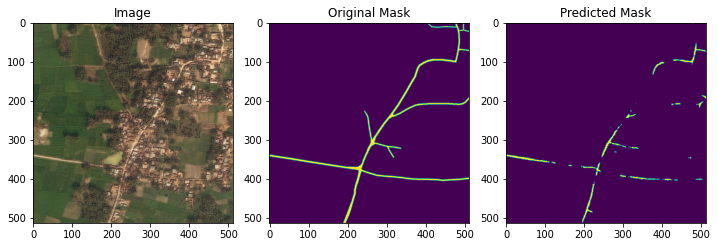

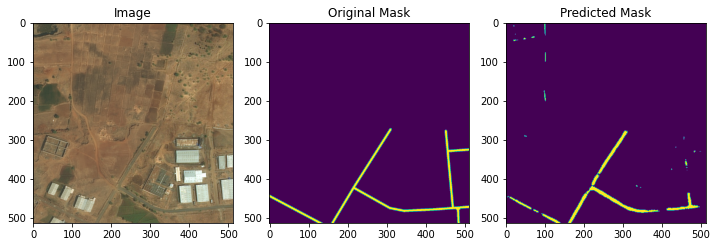

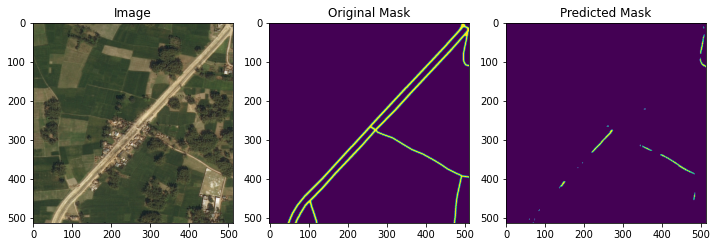

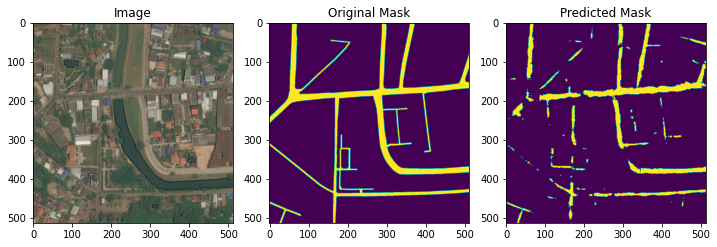

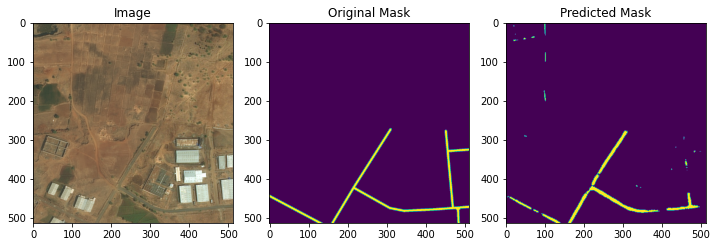

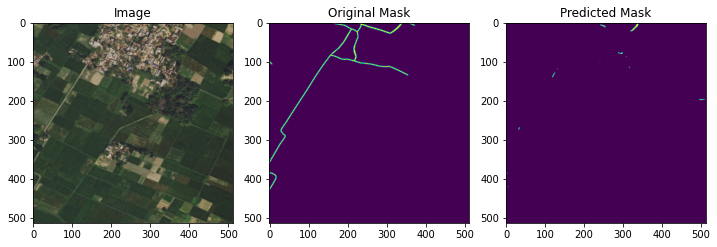

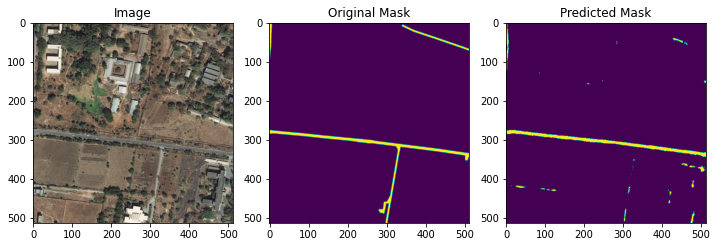

In [ ]:
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path,masked_path)

# 5. Evaluation

In [ ]:
evalImagePaths = open(TEST_PATHS).read().strip().split("\n")
iou=0
for path in evalImagePaths:
	iou+=IOU(unet,path,masked_path)

print("IOU",iou/623)	

IOU 0.4303891532111928
